<a href="https://colab.research.google.com/github/computational-neurology/workshop2025/blob/main/03_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network simulation

We will now move from single node dynamics to dynamical networks. The data will become more complex with many interactions and we need appropriate methods to extract meaningful patterns from the data.

## Part 1: Connectivity
# Learning goals

- Explain how different connectivity characteristics influence the resulting dynamics

### Introduction of Hopf model
To understand the effect of connectivity on model dynamics, we will use an adaptation of the Hopf model/ Stuart-Landau model. The model simulates the activity of all cortical ROIs, with their intercommunication determined by the empirical structural connectivity (SC) matrix, $A$.
The elements of the connectivity matrix are $C_{ij} = 0$ if no fiber bundle exist projecting from ROI $i$ to ROI $j$.
 Otherwise, $A_{ij}$ represent the weight of that connection. See Ref. [1] for a detailed description of the complete model and its resulting spatio-temporal dynamics.

The dynamics of a single Stuart-Landau system [2,3] is given by the following differential equation, with complex variable $z$:

$\dot{z} \;=\; (a + i\omega)\,z \;+\; z \, |z^2|$

We will not consider the bifurcation parameter further and set it to zero. $\omega$ the natural frequency of oscillation.

The dynamics of each ROI will follow the equation above, coupled via the connectivity matrix. Each region is provided with an additive Guassian noise $\xi(t)$ of standard deviation $\beta$. The activity of each ROI in the complete system is described by:

$\dot{z}_j \;=\; (a_j + i\omega_j)\,z_j \;+\; z_j \, |z_j^2| \;+\; g \sum_{j=1}^N C_{ij} (z_i - z_j) \;+\; \beta \xi_j(t)$.

As you learned in the previous lectures, $g$ is a global coupling parameter that re-scales the weights of every connection. It controls the level of synchrony of the coupled system. When $g=0$, the system is uncoupled and all ROIs behave independently.
As $g$ increases, the interdependence between ROIs becomes stronger and may lead to a global synchronised state.

--------------
[1] G. Deco, M.L. Kringelbach, B.K. Jirsa & P. Ritter, "The dynamics of resting fluctuations in the brain: metastability and its dynamical core." *Sci. Reps.* **7**:3095 (2017).

[2] L.D. Landau, "On the problem of turbulence". *Dokl. Akad. Nauk SSSR* **44**(8), 339-349  (1944).

[3] J.T. Stuart, "On the non-linear mechanics of hydrodynamic stability". *J. Fluid Mechcs* **4**(1), 1-21 (1958).

In [ ]:
%%capture
import sys
!{sys.executable} -m pip install git+https://github.com/neurolib-dev/neurolib.git
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install nilearn


# @title Run this to install dependencies

In [ ]:
# Let's import all the relevant libraries
from neurolib.models.hopf import HopfModel
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

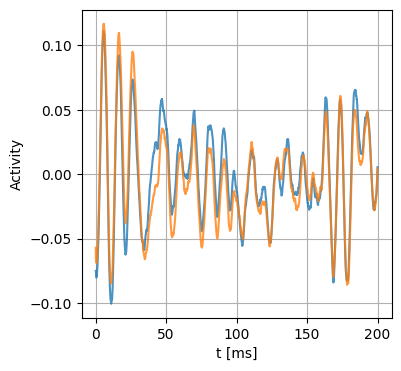

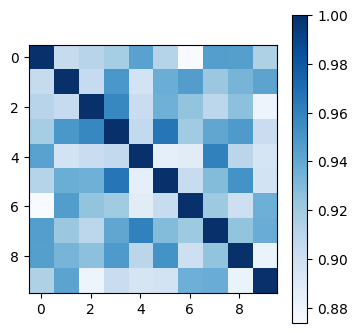

In [ ]:
# This is one implementaton of the Hopf model based on Neurolib
# functional connectivity measure
correlation_measure = ConnectivityMeasure(kind='correlation')

# setting parameters
# Number of brain regions
N = 10

# cmat is the structural connectivity matrix (here we start with a fully
# connected network)
cmat = 0.5*np.ones((N,N))

# dmat is the delay matrix, at the moment we consider instantaneous interactions
# between brain regions, so no delays
dmat = np.zeros((N,N)) # no delays

# We import the model
model = HopfModel(Cmat=cmat, Dmat=dmat)

# intrinsic angular frequency of the oscillation (omega)
model.params['w'] =  0.2 * np.pi

# set the noise here
model.params['sigma_ou'] = 0.02

# set the global coupling parameter G here
model.params['K_gl'] = 1

# duration of the simulation (in ms)
model.params['duration'] = 200

# bifurcation parameter (we will disregard it for now)
model.params['a'] = 0

model.run()

plt.figure(figsize=(4, 4))
plt.plot(model.t, model.x.T[:,1], alpha=0.8)
plt.plot(model.t, model.x.T[:,9], alpha=0.8)
plt.xlabel("t [ms]")
plt.ylabel("Activity")
plt.grid(True)
plt.show()

figure = plt.figure(figsize=(4, 4))
functional_connectivity = correlation_measure.fit_transform([model.x.T])
tcf = plt.imshow(np.squeeze(functional_connectivity), cmap=plt.cm.Blues)
figure.colorbar(tcf)

<div class="alert alert-block alert-success">
<b>Exercise 2: effects of connectivity on brain dynamics</b><p>
We will start with the adapted Hopf model and explore how the connectivity influences the dynamics. Adapt the code below. You can also copy the code first and adjust the code for each of the six exercises.

1. Let's first simulate the the fully interconnected network. Adjust the structural connectivity matrix in the code below so that all nodes are fully connected.

ANSWER: ...

2. Now, what happens if a region becomes fully disconnected?

ANSWER: ...

3. What happens if you change the connections to slightly less than 1, i.e. 0.9?

ANSWER: ...

4. Repeat all the above steps but now change the coupling parameter to 0, 0.5 and 1. How does the coupling parameter influence the dynamics?

ANSWER: ...

5. Create a structural connectivity matrix that is not homogeneous, i.e., the nodes are not equally connected with each other. Create a completely random network first (e.g., using the np.random function). The connections between different regions along the diagonal should be between 0 and 1 and the self-connections (along the diagonal) should be 1. What are the effects on the time series and on functional connectivity?

ANSWER: ...

6. Now, create two modules within the network that are connected by one node. Please draw the matrix first that you want to create and transfer it to code. How do the time series from one (random) node of one community and one (random) node of the other community behave in dependance of the coupling and the connector hub connectivity?

ANSWER: ...

   
<p>
 -End of exercise-
 </div>

In [ ]:
# solution to exercise here:

### Check your learning goals!
### Learning goals

<input type="checkbox" id="4" name="4" value="yes">
<label for="vehicle1">I can explain how different connectivity characteristics influence the resulting dynamics</label><br>

## Part 2: Fitting

### Learning goals
- explain why model fitting is needed
- perform a fitting procedure for a two-node problem
- explain appropriate fitting methods for brain networks

Imagine you have a dataset and you want to simulate the time series. How do you make sure that the parameters are chosen in such a way that they represent the data best? Let's try out the manual way first.

<b>Exercise 3 </b><p>

### Fitting different time series

You will be given two sets of time series with 2 regions that we created used two different sets of model parameters. You will be given a list of all the parameters used except for one. You have to recreate these time series by adjusting the model parameters G (the coupling parameter) in Model A and Omega (the instrinsic frequency) in Model B. Your goal is to choose the model parameter of both Model A and B in such a way that the time series that you create look as close as possible to the ones you are provided with. The process to find the parameters that were used to generate artificial data is called parameter recovery.

You will find the time series for Model A as model_a.npy, and so on. Please first find your own solution and write it down and then compare it with the others and write down the adapted solution after the discussion. In A and B, since there are only two nodes, you can guess the best parameter based on how similar your simulated timeseries are to the empirical ones. In C you should try to fit the resulting functional connectivity matrix.

You will be given a range of possible parameters. Try out the best fitting strategy and reflect on how you proceeded. To ensure that the starting point is the same as with the artificial data, please params["seed"] = 42 in your model.

## Model parameters Model A:
### Known parameters:
   
      w:  0.7 * np.pi
      Sigma_ou: 0.1
      Cmat: np.array([[1, 0.02], [0.02, 1]])
      Dmat: 0 for each connection
      Duration: 50ms

### Parameter search for:
            
      G (between 0.5 and 2.5)

## Model parameters Model B:
### Known parameters:

      G: 0.5
      Sigma_ou: 0.1
      Cmat: np.array([[1, 0.02], [0.02, 1]])
      Dmat: 0 for each connection
      Duration: 50ms

### Parameter search for:
      
      Omega (between 0.1 and 1.8)

## Model parameters Model C:
### Known parameters:

      w:  1.3 * np.pi
      Sigma_ou: 0.1
      Cmat: np.array([[1.0, 0.02, 0.04, 0.05, 0.02],
                      [0.02, 1.0, 0.03, 0.01, 0.01],
                      [0.02, 0.01, 1.0, 0.01, 0.04],
                      [0.05, 0.01, 0.06, 1.0, 0.06],
                      [0.07, 0.02, 0.03, 0.08, 1.0]])
      Dmat: 0 for each connection
      Duration: 50ms

### Parameter search for:

      G (between 0.1 and 2.8)

#### Write down your answer here:
#### Model A:
Group =

Own solution for G =

Adapted solution for G after discussion =

#### Model B:
Group =

Own solution for Omega =

Adapted solution for Omega after discussion =


#### Model C:
Group =

Own solution for G =

Adapted solution for G after discussion =


### What was your strategy on finding the right parameter?

ANSWER:


Rate the efficiency and complexity of the strategy:

ANSWER:


If you were to program a strategy, how would it look like?

ANSWER:


How would you adapt the strategy if you had more nodes?

ANSWER:
<p>
 -End of exercise-
    </div>

In [ ]:
# solution to exercise here:

## Further reading material
### Graph theory
Olaf Sporns. Networks of the Brain. MIT Press, 2010
Marcus Kaiser. A tutorial on connectome analysis, 2011. https://www.dynamic-connectome.org/pubs/Kaiser2011Neuroimage.pdf

### Model fitting
A tutorial on model fitting. https://training.incf.org/lesson/model-fitting-i-intro-lecture